In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e6/sample_submission.csv
/kaggle/input/playground-series-s4e6/train.csv
/kaggle/input/playground-series-s4e6/test.csv


# Data

In [2]:
train_df = pd.read_csv("/kaggle/input/playground-series-s4e6/train.csv")
test_df = pd.read_csv("/kaggle/input/playground-series-s4e6/test.csv")

sample = pd.read_csv("/kaggle/input/playground-series-s4e6/sample_submission.csv")

In [3]:
ord_cols = ["Application order", "Previous qualification", "Mother's qualification", "Father's qualification"]

cat_cols = ["Marital status", "Application mode", "Nacionality", "Course", "Mother's occupation", "Father's occupation", 
            "Daytime/evening attendance", "Displaced", "Educational special needs", "Debtor", "Tuition fees up to date", 
            "Gender", "Scholarship holder", "International"]

num_cols = ["Previous qualification (grade)", "Admission grade", "Age at enrollment", 
            "Curricular units 1st sem (credited)", "Curricular units 1st sem (enrolled)", "Curricular units 1st sem (evaluations)", 
            "Curricular units 1st sem (approved)", "Curricular units 1st sem (grade)", "Curricular units 1st sem (without evaluations)", 
            "Curricular units 2nd sem (credited)", "Curricular units 2nd sem (enrolled)", "Curricular units 2nd sem (evaluations)", 
            "Curricular units 2nd sem (approved)", "Curricular units 2nd sem (grade)", "Curricular units 2nd sem (without evaluations)", 
            "Unemployment rate", "Inflation rate", "GDP"]

target = ["Target"]

# Imports

In [4]:
from scipy import stats
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.compose import make_column_transformer, ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
from sklearn.utils import class_weight

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
import keras
from keras import models
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import layers
from tensorflow.keras.layers import Dense, InputLayer

import warnings
warnings.filterwarnings('ignore')

2024-06-22 00:30:39.023074: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-22 00:30:39.023203: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-22 00:30:39.302909: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Num GPUs Available:  2


# Pipeline

In [5]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])


ode_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ode', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])


ohe_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [6]:
col_trans = ColumnTransformer(transformers=[
    ('num_p', num_pipeline, num_cols),
    ('ode_p', ode_pipeline, ord_cols),
    ('ohe_p', ohe_pipeline, cat_cols),
    ],
    remainder='passthrough', 
    n_jobs=-1)

In [7]:
pipeline = Pipeline(steps=[
    ('preprocessing', col_trans)
])

In [8]:
def create_bargraphs(data, cat_cols):
    for col in cat_cols:
        data[col] = pd.Categorical(data[col], ordered=True)
        category_counts = data[col].value_counts().sort_index()
        plt.figure(figsize=(6, 4))
        category_counts.plot(kind='bar')
        plt.title(f'Bar Graph for {col}')
        plt.xlabel(col)
        plt.ylabel('Frequency')
        plt.xticks(rotation=90, fontsize=6)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

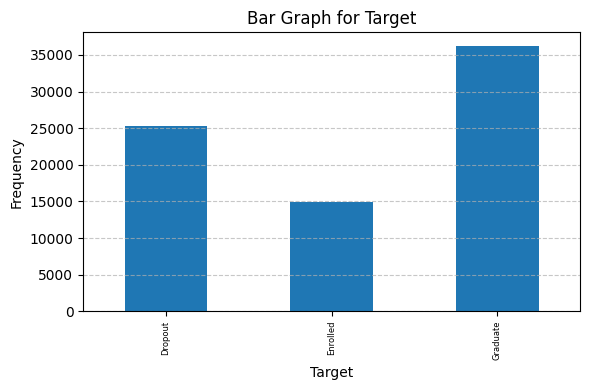

In [9]:
create_bargraphs(train_df, target)

In [10]:
X = train_df.drop(columns=['id', 'Target'], axis=1)
y = train_df['Target']

In [11]:
X_preprocessed = pipeline.fit_transform(X)

In [12]:
label_mapping = {'Dropout': 0, 'Enrolled': 1, 'Graduate': 2}
encoded_y = y.map(label_mapping)

In [13]:
print(encoded_y.dtype)

category


In [14]:
encoded_y = encoded_y.astype(int)

In [15]:
print(encoded_y.dtype)

int64


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, encoded_y, test_size=0.15, random_state=25)

Before Resampling we will try using Class weights to influence our accuracy with our imbalanced data set

# Class Weights

In [17]:
class_labels = np.unique(y_train)

weights = class_weight.compute_class_weight('balanced', classes=class_labels, y=y_train)

class_weights = dict(zip(class_labels, weights))

In [18]:
print(class_weights)

{0: 1.0100633619083117, 1: 1.705072748721982, 2: 0.7025047794951557}


**Class Weights is not working so we will instead move to Resampling, SMOTE, and/or KNN**

# Oversampling Minority Class

In [19]:
from imblearn.over_sampling import RandomOverSampler

t = [(d) for d in encoded_y if d==0]
s = [(d) for d in encoded_y if d==1]
p = [(d) for d in encoded_y if d==2]
print('Before Over-Sampling: ')
print('Samples in class 0: ',len(t))
print('Samples in class 1: ',len(s))
print('Samples in class 2: ',len(p))

Before Over-Sampling: 
Samples in class 0:  25296
Samples in class 1:  14940
Samples in class 2:  36282


In [20]:
OverS = RandomOverSampler(random_state=42)

X_Over, Y_Over = OverS.fit_resample(X_preprocessed, encoded_y)

# each class after Over-Sampling
t = [(d) for d in Y_Over if d==0]
s = [(d) for d in Y_Over if d==1]
p = [(d) for d in Y_Over if d==2]
print('After Over-Sampling: ')
print('Samples in class 0: ',len(t))
print('Samples in class 1: ',len(s))
print('Samples in class 2: ',len(p))

After Over-Sampling: 
Samples in class 0:  36282
Samples in class 1:  36282
Samples in class 2:  36282


In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_Over, Y_Over, test_size=0.15, random_state=25)

**With Random Oversampling**

                    precision    recall  f1-score   support

         Dropout       0.86      0.81      0.84      5404
        Enrolled       0.74      0.72      0.73      5561
        Graduate       0.79      0.86      0.82      5362

        accuracy                           0.80     16327
       macro avg       0.80      0.80      0.80     16327
    weighted avg       0.80      0.80      0.80     16327

Our accuracy is decreased however we are doing much better at predicting the "Enrolled" target value

# Undersampling the Majority

In [22]:
from imblearn.under_sampling import RandomUnderSampler

t = [(d) for d in encoded_y if d == 0]
s = [(d) for d in encoded_y if d == 1]
p = [(d) for d in encoded_y if d==2]

print('Before Under-Sampling: ')
print('Samples in class 0: ', len(t))
print('Samples in class 1: ', len(s))
print('Samples in class 2: ', len(p))

UnderS = RandomUnderSampler(random_state=42,
                            replacement=True)

X_Under, Y_Under = UnderS.fit_resample(X_preprocessed, encoded_y)

t = [(d) for d in Y_Under if d == 0]
s = [(d) for d in Y_Under if d == 1]
p = [(d) for d in Y_Under if d==2]

print('After Under-Sampling: ')
print('Samples in class 0: ', len(t))
print('Samples in class 1: ', len(s))
print('Samples in class 2: ', len(p))

Before Under-Sampling: 
Samples in class 0:  25296
Samples in class 1:  14940
Samples in class 2:  36282
After Under-Sampling: 
Samples in class 0:  14940
Samples in class 1:  14940
Samples in class 2:  14940


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_Under, Y_Under, test_size=0.15, random_state=25)

**With Random UnderSampling**

                    precision    recall  f1-score   support

         Dropout       0.82      0.84      0.83      2241
        Enrolled       0.74      0.62      0.68      2281
        Graduate       0.75      0.85      0.80      2201

        accuracy                           0.77      6723
       macro avg       0.77      0.77      0.77      6723
    weighted avg       0.77      0.77      0.77      6723

# SMOTE

In [23]:
from imblearn.over_sampling import SMOTE

t = [(d) for d in encoded_y if d==0]
s = [(d) for d in encoded_y if d==1]
p = [(d) for d in encoded_y if d==2]

print('Before Over-Sampling: ')

print('Samples in class 0: ',len(t))
print('Samples in class 1: ',len(s))
print('Samples in class 2: ',len(p))

smote = SMOTE()

X_OverSmote, Y_OverSmote = smote.fit_resample(X_preprocessed, encoded_y)

t = [(d) for d in Y_OverSmote if d==0]
s = [(d) for d in Y_OverSmote if d==1]
p = [(d) for d in Y_OverSmote if d==2]


print('After Over-Sampling: ')
print('Samples in class 0: ',len(t))
print('Samples in class 1: ',len(s))
print('Samples in class 2: ',len(p))

Before Over-Sampling: 
Samples in class 0:  25296
Samples in class 1:  14940
Samples in class 2:  36282
After Over-Sampling: 
Samples in class 0:  36282
Samples in class 1:  36282
Samples in class 2:  36282


In [37]:
X_train, X_test, y_train, y_test = train_test_split(X_OverSmote, Y_OverSmote, test_size=0.15, random_state=25)

**With SMOTE**

                    precision    recall  f1-score   support

         Dropout       0.88      0.81      0.85      5404
        Enrolled       0.75      0.78      0.76      5561
        Graduate       0.82      0.84      0.83      5362

        accuracy                           0.81     16327
       macro avg       0.82      0.81      0.81     16327
    weighted avg       0.81      0.81      0.81     16327

# KNN

In [24]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X_train, y_train)

train_distances, _ = knn.kneighbors(X_train)
test_distances, _ = knn.kneighbors(X_test)



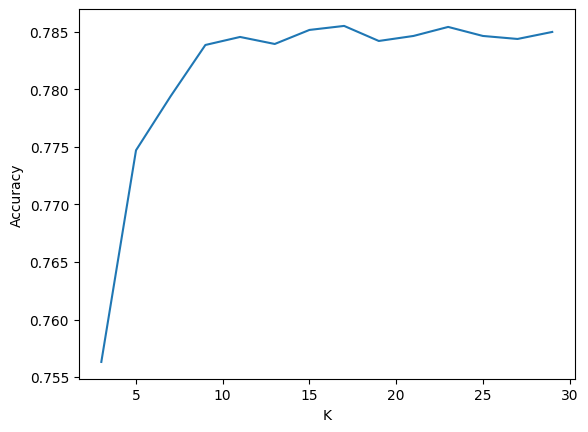

In [25]:
acc = {}
for k in range(3, 30, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    knn_pred = knn.predict(X_test)
    acc[k] = accuracy_score(y_test, knn_pred)
    
# PLotting K v/s accuracy graph
plt.plot(range(3,30,2), acc.values())
plt.xlabel('K')
plt.ylabel('Accuracy')
plt.show()

In [26]:
knn = KNeighborsClassifier(n_neighbors=17)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)
print(accuracy_score(y_test, knn_pred))
print(classification_report(y_test, knn_pred))

0.785502700818958
              precision    recall  f1-score   support

           0       0.90      0.75      0.82      3832
           1       0.58      0.50      0.54      2225
           2       0.79      0.93      0.85      5421

    accuracy                           0.79     11478
   macro avg       0.76      0.73      0.74     11478
weighted avg       0.79      0.79      0.78     11478



acc = 0.785502700818958
                   
                   precision    recall  f1-score   support

               0       0.90      0.75      0.82      3832
               1       0.58      0.50      0.54      2225
               2       0.79      0.93      0.85      5421

        accuracy                           0.79     11478
       macro avg       0.76      0.73      0.74     11478
    weighted avg       0.79      0.79      0.78     11478


# Model Building

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, encoded_y, test_size=0.15, random_state=25)

In [29]:
model = models.Sequential([
    layers.InputLayer(input_shape=(X_train.shape[1],)),
    layers.Dense(16, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

print(model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 16)             │         3,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,539 (37.26 KB)

 Trainable params: 9,539 (37.26 KB)

 Non-trainable params: 0 (0.00 B)

None


In [30]:
print(X_train.dtype)
print(y_train.dtype)
print(y_train)

float64
int64
32959    2
10895    0
17916    1
33423    2
43026    2
        ..
35702    2
26767    1
6618     0
24894    1
29828    1
Name: Target, Length: 38097, dtype: int64


In [31]:
print(np.unique(y_train))
print(class_weights)

[0 1 2]
{0: 1.0100633619083117, 1: 1.705072748721982, 2: 0.7025047794951557}


In [45]:
es = EarlyStopping(monitor='val_acc', mode='min', verbose=1, patience=15)

history = model.fit(X_train, y_train, epochs=100, batch_size=25, validation_split=0.15, verbose=0, callbacks=[es])

test_loss, test_acc = model.evaluate(X_test, y_test)

print(f'Test accuracy: {test_acc}')

359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8194 - loss: 0.5744
Test accuracy: 0.8183481693267822


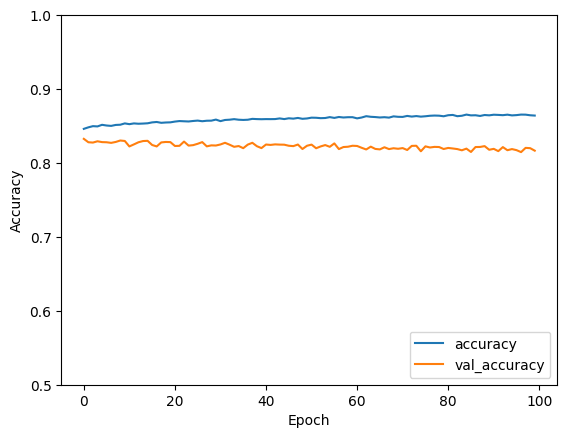

In [46]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show()

In [47]:
reverse_label_mapping = {0: 'Dropout', 1: 'Enrolled', 2: 'Graduate'}

decoded_test = [reverse_label_mapping[label] for label in y_test]

In [48]:
dnn_pred = model.predict(X_test)

dnn_pred = np.argmax(dnn_pred, axis=1)

#flattened = []

print(dnn_pred)

#for arr in dnn_pred:
    #flattened.extend(arr)

decoded_pred_dnn = [reverse_label_mapping[label] for label in dnn_pred]

accuracy_dnn = accuracy_score(decoded_test, decoded_pred_dnn)

print("Accuracy: ", accuracy_dnn)

359/359 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
[0 1 0 ... 2 0 2]
Accuracy:  0.8183481442760062


In [49]:
print(classification_report(decoded_test, decoded_pred_dnn))

              precision    recall  f1-score   support

     Dropout       0.87      0.84      0.85      3832
    Enrolled       0.62      0.58      0.60      2225
    Graduate       0.85      0.91      0.88      5421

    accuracy                           0.82     11478
   macro avg       0.78      0.77      0.78     11478
weighted avg       0.82      0.82      0.82     11478



**Without Resampling the dataset**

                   precision    recall  f1-score   support

         Dropout       0.87      0.84      0.85      3832
        Enrolled       0.62      0.58      0.60      2225
        Graduate       0.85      0.91      0.88      5421

        accuracy                           0.82     11478
       macro avg       0.78      0.77      0.78     11478
    weighted avg       0.82      0.82      0.82     11478

# Conclusion

While Resampling had a positive effect on predicting our "Enrolled" target, the noise it gave our model reduced our total accuracy to the point that not resampling still had a better accuracy score. Our K-Nearest Neighbors had similar results to our resampling as well. 


Overall, our best resampling method was SMOTE and our best model is still our base DNN model with the preprocessed pipeline and encoded y variables. This model does not beat our accuracy score we received on our CatBoostClassifier, however it does provide worthwhile insight into how resampling methods may affect a DNN. 

In the future, I'd like to keep trying to get class_weight to work as I believe it will have productive results in tuning our model to predict "Enrolled" with a higher f1-score and keep our high metrics for "Dropout" and "Graduate" from our baseline DNN model. 

# Feedback

If anyone has suggestions on how to get class_weight to work properly please kindly send it my way as class_weight=class_weights when fitting has produced a KeyError: 1 everytime I have tried to call it. I believe this may be because we are working with a multi-class classification model however everything I've read online says that this should still work, and yet it won't. Thank you!!